# Import

In [480]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [481]:
movies_df = pd.read_csv('../data/movies.csv')

# EDA and Preprocessing

In [482]:
movies_df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [483]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

In [485]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.9)

qualified_movies = movies_df.copy().loc[movies_df['vote_count'] >= m]
qualified_movies.shape

(481, 24)

In [486]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [487]:
movies_df['score'] = movies_df.apply(weighted_rating, axis=1)

In [488]:
movies_df = movies_df.sort_values('score', ascending=False)

movies_df[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

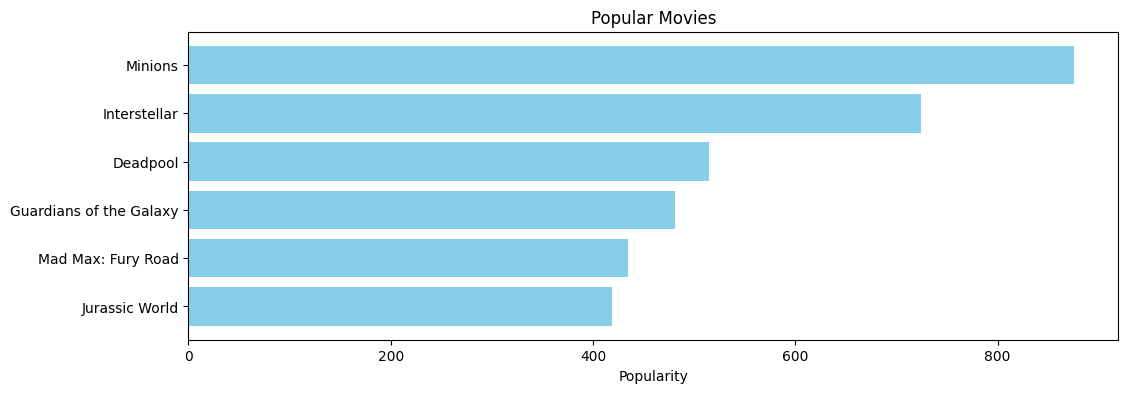

In [489]:
pop = movies_df.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

In [490]:
movies_df.isnull().sum()

index                      0
budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
cast                      43
crew                       0
director                  30
score                      0
dtype: int64

# Model

In [491]:
selected_features = ['title', 'genres', 'overview', 'score', 'keywords', 'tagline', 'cast', 'director']

In [492]:
for feature in selected_features:
    movies_df[feature] = movies_df[feature].fillna('')

In [493]:
combined_features = movies_df['title'] + ' ' + movies_df['genres'] + ' ' + 'overview' + ' ' + str(movies_df['score']) + ' ' + movies_df ['keywords'] + ' ' + movies_df ['tagline'] + ' ' + movies_df ['cast'] + ' ' + movies_df['director']

In [494]:
print(combined_features)

1881    The Shawshank Redemption Drama Crime overview ...
662     Fight Club Drama overview 1881    8.059258\n66...
65      The Dark Knight Drama Action Crime Thriller ov...
3232    Pulp Fiction Thriller Crime overview 1881    8...
96      Inception Action Thriller Science Fiction Myst...
                              ...                        
1652    Dragonball Evolution Action Adventure Fantasy ...
91      Independence Day: Resurgence Action Adventure ...
3746    The Boy Next Door Thriller overview 1881    8....
210     Batman & Robin Action Crime Fantasy overview 1...
242     Fantastic Four Action Adventure Science Fictio...
Length: 4803, dtype: object


In [495]:
vectorizer = TfidfVectorizer()

In [496]:
vectorized_data = vectorizer.fit_transform(combined_features)

In [497]:
from sklearn.decomposition import TruncatedSVD
param_grid = {
    'n_components': [50, 100, 150, 200],
    'algorithm': ['randomized', 'arpack'],
    'n_iter': [5, 10, 20],
}

In [498]:
svd = TruncatedSVD()

In [499]:
halving_search = HalvingGridSearchCV(
    estimator=svd,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

In [500]:
halving_search.fit(vectorized_data)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 533
max_resources_: 4803
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 533
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\nguye\Documents\Github\movies-suggestion\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(
c:\Users\nguye\Documents\Github\movies-suggestion\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


----------
iter: 1
n_candidates: 8
n_resources: 1599
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\nguye\Documents\Github\movies-suggestion\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\nguye\Documents\Github\movies-suggestion\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


----------
iter: 2
n_candidates: 3
n_resources: 4797
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\nguye\Documents\Github\movies-suggestion\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\nguye\Documents\Github\movies-suggestion\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


HalvingGridSearchCV(estimator=TruncatedSVD(), n_jobs=-1,
                    param_grid={'algorithm': ['randomized', 'arpack'],
                                'n_components': [50, 100, 150, 200],
                                'n_iter': [5, 10, 20]},
                    scoring='f1_macro', verbose=1)

In [501]:
best_params = halving_search.best_params_
svd = TruncatedSVD(**best_params)

In [502]:
pca_features = svd.fit_transform(vectorized_data)

# Saving Model

In [503]:
import joblib

In [504]:
joblib.dump(pca_features, 'feature_extraction.pkl')

['feature_extraction.pkl']